In [1]:
from google.colab import drive
try:
  drive.mount('/content/drive', force_remount=False)
except:
  pass

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/AI_for_Health

/content/drive/MyDrive/AI_for_Health


In [3]:
data_path = "mimic-iii-clinical-database-1.4"

# Download MIMIC III Dataset

In [ ]:
mimic_zip_file_name = 'mimiciii.zip'

In [ ]:
# Download the MimicIII Demo Data for this demonstration
import os
if not os.path.exists(data_path):
    #!wget https://physionet.org/static/published-projects/mimiciii-demo/mimic-iii-clinical-database-demo-1.4.zip
    !wget --user=krithika.mkathiresan@utexas.edu --ask-password -O mimiciii.zip https://physionet.org/content/mimiciii/get-zip/1.4/

Password for user ‘krithika.mkathiresan@utexas.edu’: 
--2025-01-25 20:36:34--  https://physionet.org/content/mimiciii/get-zip/1.4/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="PhysioNet", charset="UTF-8"
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6620711553 (6.2G) [application/zip]
Saving to: ‘mimiciii.zip’

mimiciii.zip        100%[===================>]   6.17G   570KB/s    in 3h 10m  

2025-01-25 23:46:40 (567 KB/s) - ‘mimiciii.zip’ saved [6620711553/6620711553]



In [ ]:
import zipfile
if not os.path.exists(data_path):
    with zipfile.ZipFile(mimic_zip_file_name, 'r') as zip_ref:
        zip_ref.extractall()

# Load Data

In [4]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
import numpy as np

In [5]:
# Load data
patients = pd.read_csv(os.path.join(data_path,'PATIENTS.csv.gz'))
admissions = pd.read_csv(os.path.join(data_path,'ADMISSIONS.csv.gz'))
diagnoses = pd.read_csv(os.path.join(data_path,'DIAGNOSES_ICD.csv.gz'))
icustays = pd.read_csv(os.path.join(data_path,'ICUSTAYS.csv.gz'))
diagnoses_labels = pd.read_csv(os.path.join(data_path,'D_ICD_DIAGNOSES.csv.gz'))
procedures = pd.read_csv(os.path.join(data_path,'PROCEDURES_ICD.csv.gz'))
procedures_labels = pd.read_csv(os.path.join(data_path,'D_ICD_PROCEDURES.csv.gz'))
labevents = pd.read_csv(os.path.join(data_path,'LABEVENTS.csv.gz'))
lab_labels = pd.read_csv(os.path.join(data_path,'D_LABITEMS.csv.gz'))
prescriptions = pd.read_csv(os.path.join(data_path,"PRESCRIPTIONS.csv.gz"))

<ipython-input-5-ba3e8a1210c1>:11: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv(os.path.join(data_path,"PRESCRIPTIONS.csv.gz"))


# Clean data for extremely large age values

In [6]:
# Calculate the largest date value from Admissions table
df = admissions.copy()
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
repl_for_missing_DOD = max(df['DISCHTIME']).strftime("%Y-%m-%d %H:%M:%S")
print(repl_for_missing_DOD)

2210-08-24 19:43:00


In [7]:
df = patients.copy()
df['DOD_orig'] = df['DOD']

# Impute missing DOD with this largest date value -> Age of a person will be calculated based on this age
df["DOD"] = df["DOD"].fillna(repl_for_missing_DOD)
df["DOB"] = df["DOB"].astype(str)
df["DOD"] = df["DOD"].astype(str)
df["DOD"] = df["DOD"].replace("nan", repl_for_missing_DOD)

# Calculate age function
def calculate_age(dob, dod):
  try:
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    dod_date = datetime.strptime(dod, "%Y-%m-%d %H:%M:%S")
    age = (dod_date - dob_date).days // 365
    return age
  except ValueError as e:
    print(f"Error processing dates: {e}")
    return None

# Apply calculate_age function to create "age" column
df["age"] = df.apply(lambda row: calculate_age(row["DOB"], row["DOD"]), axis=1)

# Filter out rows with age greater than or equal to 120
patients_fil = df[df["age"] < 120]

patients_fil.head(10)

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DOD_orig,age
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1,2188-11-22 00:00:00,23
5,239,255,M,2109-08-05 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,101
7,241,257,F,2031-04-03 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,1,2121-07-08 00:00:00,90
8,242,258,F,2124-09-19 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,85
9,243,260,F,2105-03-23 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,105
10,244,261,M,2025-08-04 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,1,2102-06-29 00:00:00,76
12,246,263,M,2104-06-18 00:00:00,2168-06-13 00:00:00,2168-06-13 00:00:00,NaN,1,2168-06-13 00:00:00,64
13,247,264,F,2162-11-30 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,47
14,248,265,M,2093-08-01 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,117
15,249,266,F,2090-12-17 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,119


# Prepared merged datasets

In [8]:
# Merge admissions and patients data on subject_id
merged_a_p = pd.merge(admissions, patients_fil, on="SUBJECT_ID", how="inner")
merged_a_p.drop('ROW_ID_x', axis=1, inplace=True)
merged_a_p.drop('ROW_ID_y', axis=1, inplace=True)

merged_a_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43074 entries, 0 to 43073
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SUBJECT_ID            43074 non-null  int64 
 1   HADM_ID               43074 non-null  int64 
 2   ADMITTIME             43074 non-null  object
 3   DISCHTIME             43074 non-null  object
 4   DEATHTIME             5305 non-null   object
 5   ADMISSION_TYPE        43074 non-null  object
 6   ADMISSION_LOCATION    43074 non-null  object
 7   DISCHARGE_LOCATION    43074 non-null  object
 8   INSURANCE             43074 non-null  object
 9   LANGUAGE              21866 non-null  object
 10  RELIGION              42724 non-null  object
 11  MARITAL_STATUS        33559 non-null  object
 12  ETHNICITY             43074 non-null  object
 13  EDREGTIME             21499 non-null  object
 14  EDOUTTIME             21499 non-null  object
 15  DIAGNOSIS             43054 non-null

In [9]:
# Merge icustays, admissions and patients on subject_id and hadm_id
merged_i_a_p = pd.merge(icustays, merged_a_p, on=['SUBJECT_ID', 'HADM_ID'], how="inner")
merged_i_a_p.drop("ROW_ID", axis=1, inplace=True)

merged_i_a_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45027 entries, 0 to 45026
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SUBJECT_ID            45027 non-null  int64  
 1   HADM_ID               45027 non-null  int64  
 2   ICUSTAY_ID            45027 non-null  int64  
 3   DBSOURCE              45027 non-null  object 
 4   FIRST_CAREUNIT        45027 non-null  object 
 5   LAST_CAREUNIT         45027 non-null  object 
 6   FIRST_WARDID          45027 non-null  int64  
 7   LAST_WARDID           45027 non-null  int64  
 8   INTIME                45027 non-null  object 
 9   OUTTIME               45018 non-null  object 
 10  LOS                   45018 non-null  float64
 11  ADMITTIME             45027 non-null  object 
 12  DISCHTIME             45027 non-null  object 
 13  DEATHTIME             6019 non-null   object 
 14  ADMISSION_TYPE        45027 non-null  object 
 15  ADMISSION_LOCATION 

In [10]:
# Merge prescriptions with icustays
merge_pr_i = pd.merge(prescriptions, icustays, on=['SUBJECT_ID','HADM_ID','ICUSTAY_ID'], how='inner')

# To filter for the patients with age < 120, merge with subject_id from patients_fil
merge_pr_i = pd.merge(merge_pr_i, patients_fil[['SUBJECT_ID']], on='SUBJECT_ID', how='inner')

In [11]:
# Convert the DataFrame to a dictionary to link icd9 codes to respective labels
icd9_dict = diagnoses_labels.set_index('ICD9_CODE')['SHORT_TITLE'].to_dict()

# Merge diagnosis_icd with admissions on subject_id and hadm_id
merged_a_p_d = pd.merge(merged_a_p, diagnoses, on=['SUBJECT_ID','HADM_ID'], how="inner")
merged_a_p_d.drop("ROW_ID", axis=1, inplace=True)
merged_a_p_d.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DOD_orig,age,SEQ_NUM,ICD9_CODE
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,F,2131-05-07 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,79,1.0,9678
1,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,F,2131-05-07 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,79,2.0,9693
2,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,F,2131-05-07 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,79,3.0,E9502
3,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,F,2131-05-07 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,79,4.0,E9503
4,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,F,2131-05-07 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,79,5.0,3488
5,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,F,2131-05-07 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,79,6.0,29620
6,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,F,2131-05-07 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,79,7.0,4019
7,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,...,M,2100-05-31 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,110,1.0,41041
8,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,...,M,2100-05-31 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,110,2.0,41401
9,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,...,M,2100-05-31 00:00:00,2210-08-24 19:43:00,NaN,NaN,0,NaN,110,3.0,53081


# Graph 1: Clinical Lab values



In [ ]:
# Filter the labevents table for the required metrics, and remove NA values
lab_labels_fil = lab_labels[lab_labels['LABEL'].isin(['Glucose','pH'])]
labevents_fil = pd.merge(labevents, lab_labels_fil, on='ITEMID', how='inner')
labevents_fil = labevents_fil[~labevents_fil['VALUENUM'].isna()]

# Remove records flagged abnormal
labevents_fil = labevents_fil[labevents_fil['FLAG'] != "abnormal"]

# Merge with patients and admissions data
merged_a_p_l = pd.merge(merged_a_p, labevents_fil, on=['SUBJECT_ID','HADM_ID'], how='inner')

# Group ethnicity into fewer groups
merged_a_p_l['grpd_ethnicity'] = "UNKNOWN"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("WHITE", case=False, na=False), 'grpd_ethnicity'] = "WHITE"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("PORTUGUESE", case=False, na=False), 'grpd_ethnicity'] = "WHITE"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("BLACK", case=False, na=False), 'grpd_ethnicity'] = "BLACK"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("HISPANIC", case=False, na=False), 'grpd_ethnicity'] = "HISPANIC/LATINO"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("OTHER", case=False, na=False), 'grpd_ethnicity'] = "OTHER"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("ASIAN", case=False, na=False), 'grpd_ethnicity'] = "ASIAN"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("MIDDLE EASTERN", case=False, na=False), 'grpd_ethnicity'] = "ASIAN"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("AMERICAN INDIAN", case=False, na=False), 'grpd_ethnicity'] = "AMR.INDIAN"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("PACIFIC ISLANDER", case=False, na=False), 'grpd_ethnicity'] = "PAC.ISLANDER"
merged_a_p_l.loc[merged_a_p_l['ETHNICITY'].str.contains("CARIBBEAN ISLAND", case=False, na=False), 'grpd_ethnicity'] = "PAC.ISLANDER"

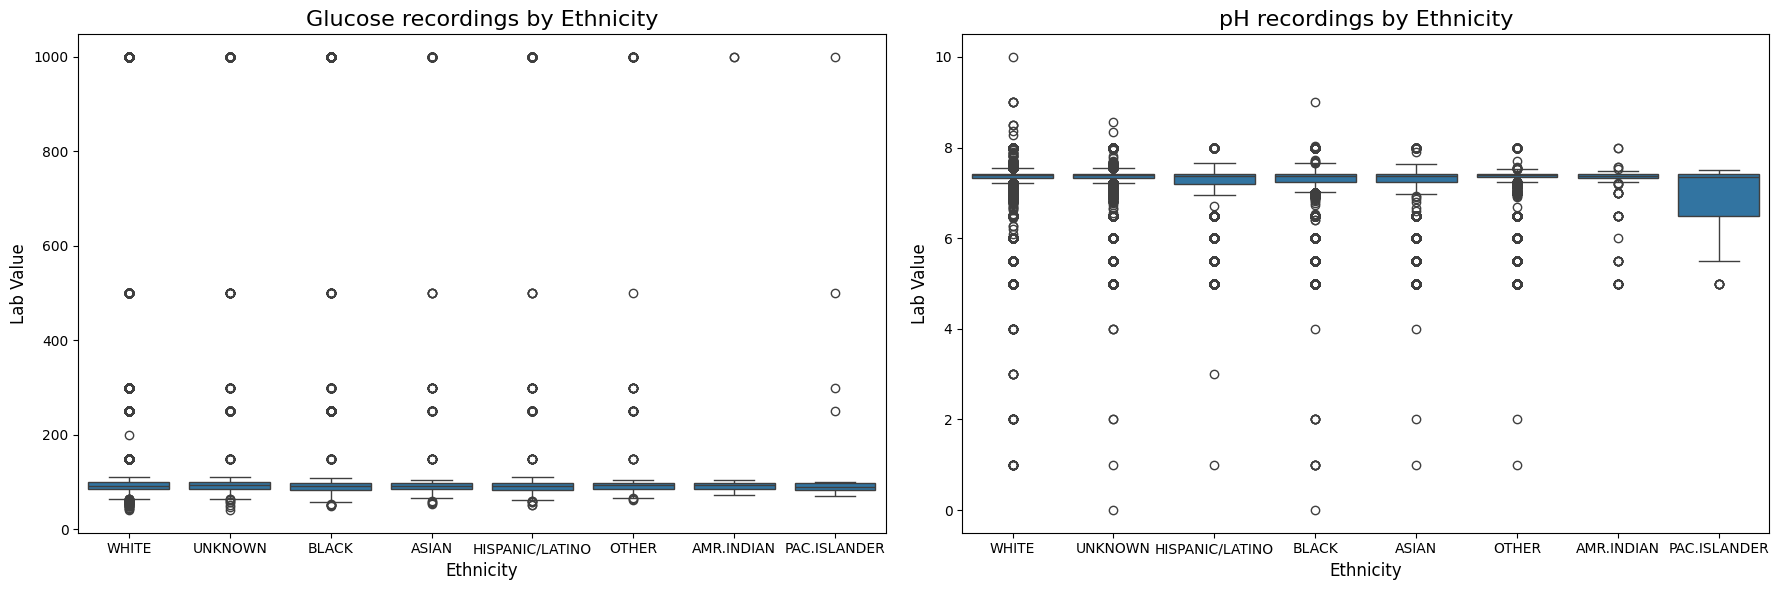

In [ ]:
glucose_data = merged_a_p_l[merged_a_p_l['LABEL'].isin(['Glucose'])]
pH_data = merged_a_p_l[merged_a_p_l['LABEL'].isin(['pH'])]

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.boxplot(data=glucose_data, x='grpd_ethnicity', y='VALUENUM')
plt.title('Glucose recordings by Ethnicity', fontsize=16)
plt.xlabel('Ethnicity', fontsize=12)
plt.ylabel('Lab Value', fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(data=pH_data, x='grpd_ethnicity', y='VALUENUM')
plt.title('pH recordings by Ethnicity', fontsize=16)
plt.xlabel('Ethnicity', fontsize=12)
plt.ylabel('Lab Value', fontsize=12)

plt.tight_layout()
plt.show()

# Graph 2: ICU Readmission rates

In [ ]:
df = merged_a_p.copy()

# Convert to datetime format
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
df['DOB'] = pd.to_datetime(df['DOB'])

# Bin patient age into buckets
bins = np.array([-1, 20, 40, 60, 80, 120])
labels = np.array(['0-20','21-40','41-60','61-80','81-120'])
df['age_at_ICU'] = (df['ADMITTIME'] - df['DOB']).dt.days // 365  # Age in years
df["age_bin"] = pd.cut(df['age_at_ICU'], bins=bins, labels=labels)

# Identify patients who have been readmitted within 30 days
#   a) Sort by patient ID and admission time
df = df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])
#   b) Shift ADMITTIME to compare with the next admission
df['next_admittime'] = df.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
#   c) Calculate time between discharge and next admission
df['time_to_next_admit'] = (df['next_admittime'] - df['DISCHTIME']).dt.days
#   d) Flag readmissions within 30 days
df['readmitted_within_30days'] = (df['time_to_next_admit'] <= 30).astype(int)
#   e) Exclude the last admission for each patient
df = df[df['next_admittime'].notna()]

# Merge with icustays
dropdupl_icustays = icustays[['SUBJECT_ID','HADM_ID','FIRST_CAREUNIT']].drop_duplicates()
merge_df = pd.merge(df, dropdupl_icustays, on=['SUBJECT_ID','HADM_ID'], how='inner')

# Calculate readmission rates by ICU unit
icu_readmission_rate = merge_df.groupby(['FIRST_CAREUNIT','age_bin'])['readmitted_within_30days'].mean()
icu_readmission_rate = pd.DataFrame(icu_readmission_rate)
icu_readmission_rate['readmitted_within_30days'] = round(icu_readmission_rate['readmitted_within_30days']*100, 2)
icu_readmission_rate.reset_index(inplace=True)
icu_readmission_rate = icu_readmission_rate.replace(np.nan,0,regex=True)

#icu_readmission_rate

<ipython-input-32-bab36318ae39>:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  icu_readmission_rate = merge_df.groupby(['FIRST_CAREUNIT','age_bin'])['readmitted_within_30days'].mean()


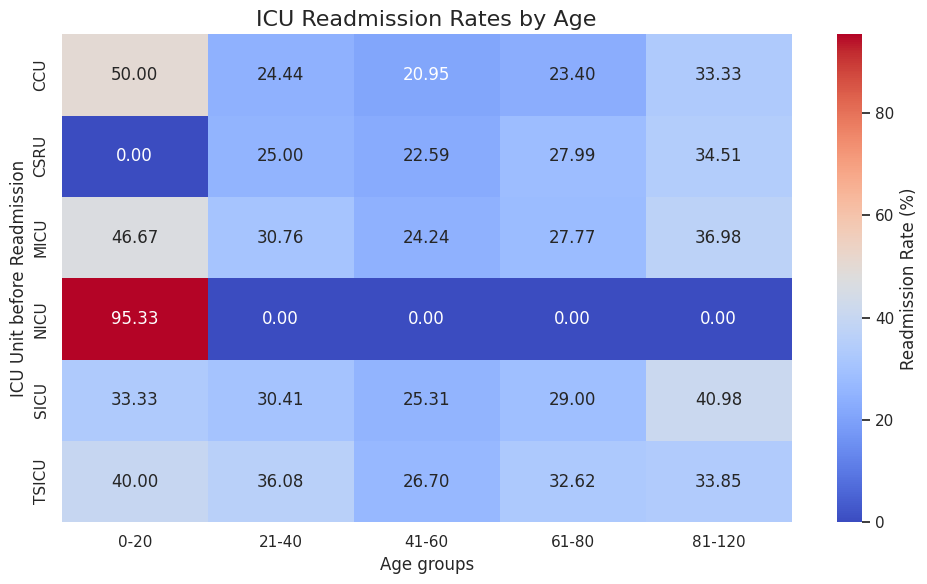

In [ ]:
# Pivot the DataFrame to reshape for the heatmap
heatmap_data = icu_readmission_rate.pivot(index='FIRST_CAREUNIT', columns='age_bin', values='readmitted_within_30days')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Readmission Rate (%)'})

# Add titles and labels
plt.title('ICU Readmission Rates by Age', fontsize=16)
plt.xlabel('Age groups', fontsize=12)
plt.ylabel('ICU Unit before Readmission', fontsize=12)

# Show the heatmap
plt.tight_layout()
plt.show()


# Graph 3 - Mortality rate over different features

In [ ]:
df = merged_i_a_p.copy()

# Calculate ICU mortality rate
df['ICU_expire'] =( ~df['DEATHTIME'].isna()).astype(int)

# Calculate the mortality rate across gender and admission type
expire_acr_demog = df.groupby(["GENDER","ADMISSION_TYPE"]).agg(
    num_expire=('ICU_expire','sum'),
    rowcount=('ICU_expire','count')
).reset_index()
pivot = expire_acr_demog.pivot(index="ADMISSION_TYPE", columns="GENDER", values=["num_expire","rowcount"]) #Reshaping to make %mortality calculation easier
pivot.columns = ['num_expire_F','num_expire_M','rowcount_F','rowcount_M']
pivot.reset_index(inplace=True)
pivot['mortality_F'] = (pivot['num_expire_F'])/(pivot['rowcount_F']+pivot['rowcount_M'])
pivot['mortality_M'] = (pivot['num_expire_M'])/(pivot['rowcount_F']+pivot['rowcount_M'])
melt_pivot = pd.melt(pivot, id_vars=['ADMISSION_TYPE'], value_vars=['mortality_F', 'mortality_M'], var_name='Gender', value_name='Mortality_rate')
melt_pivot.loc[melt_pivot['Gender']=='mortality_F','Gender'] = 'F'
melt_pivot.loc[melt_pivot['Gender']=='mortality_M','Gender'] = 'M'
melt_pivot['Mortality_rate'] = round(melt_pivot['Mortality_rate']*100,2)

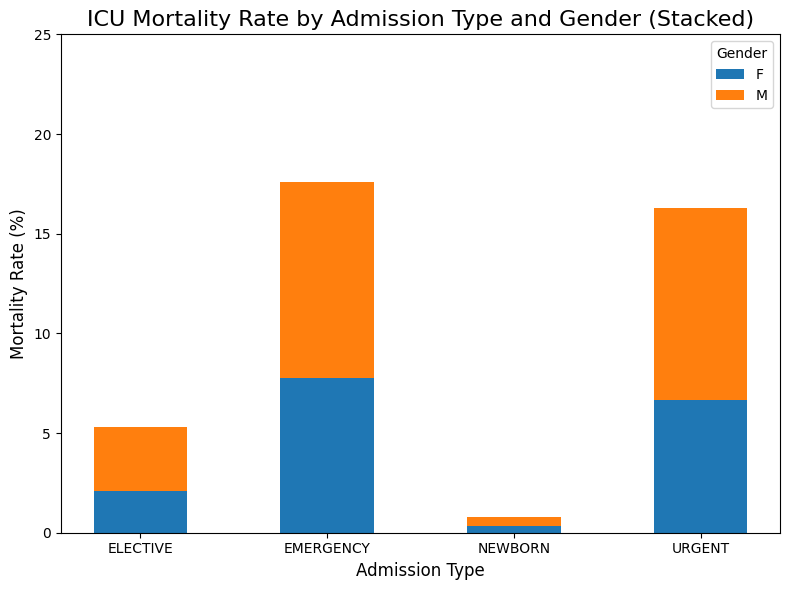

In [ ]:
# Create a pivot table to restructure data for stacking
pivot = melt_pivot.pivot(index="ADMISSION_TYPE", columns="Gender", values="Mortality_rate").fillna(0)

# Plot settings
x_labels = pivot.index
x = np.arange(len(x_labels))  # X positions for the admission types

fig, ax = plt.subplots(figsize=(8, 6))

# Stacking bars for each gender
bottom_values = np.zeros(len(x))  # Initialize bottom for stacking
for gender in pivot.columns:
    ax.bar(x, pivot[gender], width=0.5, label=gender, bottom=bottom_values)
    bottom_values += pivot[gender]  # Update bottom values for stacking

# Customize the chart
ax.set_title("ICU Mortality Rate by Admission Type and Gender (Stacked)", fontsize=16)
ax.set_xlabel("Admission Type", fontsize=12)
ax.set_ylabel("Mortality Rate (%)", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=10)
ax.legend(title="Gender", fontsize=10)
ax.set_ylim(0, 25)  # Set y-axis limits between 0 and 100

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Graph 4: Medication Usage

In [ ]:
df = merge_pr_i.copy()

# Filter for medications prescribed during ICU stay
df['STARTDATE'] = pd.to_datetime(df['STARTDATE'])
df['ENDDATE'] = pd.to_datetime(df['ENDDATE'])
df = df[(df['STARTDATE'] >= df['INTIME']) & (df['STARTDATE'] <= df['OUTTIME'])]

# Count occurrences of each medication by drug class
common_medications = df.groupby(['DRUG_TYPE','DRUG'])['SUBJECT_ID'].count().reset_index()
common_medications.columns = ['Drug Class', 'Medication','Count']
print(common_medications.sort_values(by='Count', ascending=False).head(10))

# Count medications by drug class
medications_by_class = df.groupby('DRUG_TYPE')['DRUG'].count().reset_index()
medications_by_class.columns = ['Drug Class', 'Count']
print(medications_by_class.sort_values(by='Count', ascending=False).head(10))


     Drug Class            Medication  Count
2208       MAIN    Potassium Chloride  74631
94         BASE                   D5W  60809
1151       MAIN            Furosemide  58634
113        BASE                    NS  51478
1366       MAIN               Insulin  48480
59         BASE  0.9% Sodium Chloride  46164
107        BASE  Iso-Osmotic Dextrose  33950
143        BASE                    SW  31599
1699       MAIN            Metoprolol  31346
67         BASE           5% Dextrose  29452
  Drug Class    Count
2       MAIN  1091754
1       BASE   366506
0   ADDITIVE     9840


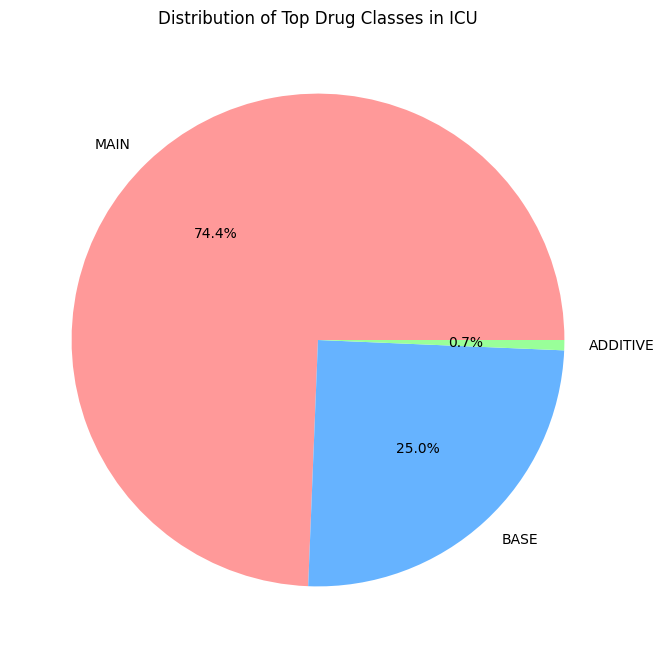

In [ ]:
# Pie chart of drug classes
top_classes = medications_by_class.sort_values(by='Count', ascending=False)
plt.figure(figsize=(8, 8))
plt.pie(top_classes['Count'], labels=top_classes['Drug Class'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0'])
plt.title('Distribution of Top Drug Classes in ICU')
plt.show()

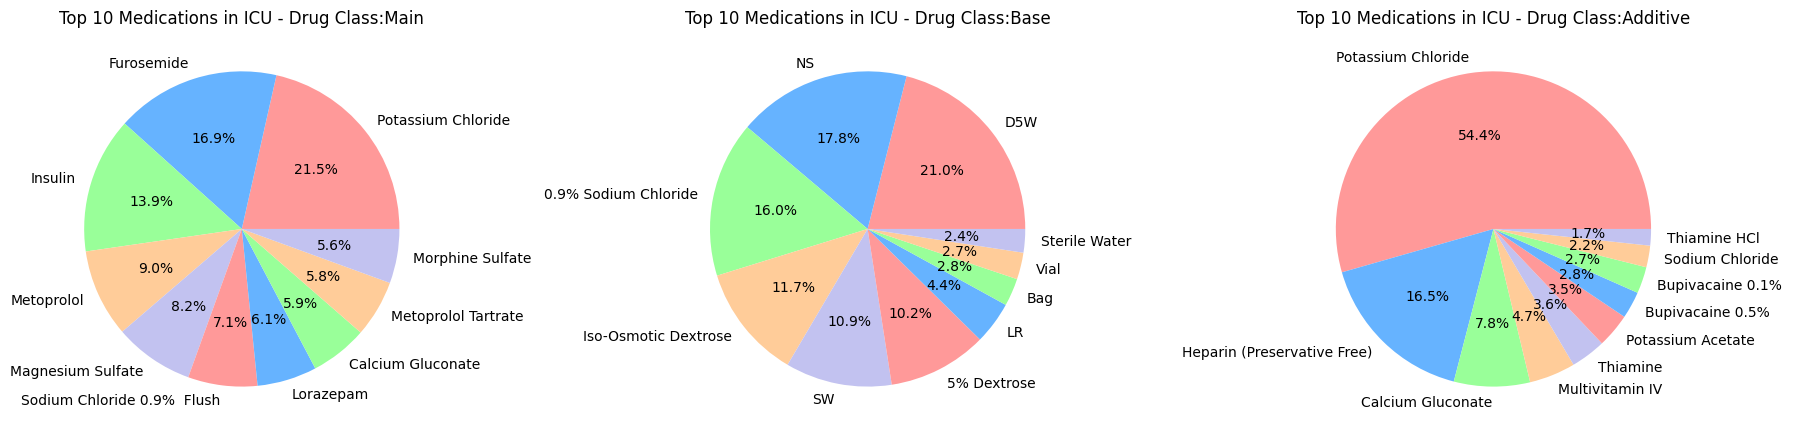

In [ ]:
# Pie chart of drug classes
top_classes_main = common_medications[common_medications['Drug Class'] == 'MAIN'].sort_values(by='Count', ascending=False).head(10)
top_classes_base = common_medications[common_medications['Drug Class'] == 'BASE'].sort_values(by='Count', ascending=False).head(10)
top_classes_adtv = common_medications[common_medications['Drug Class'] == 'ADDITIVE'].sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.pie(top_classes_main['Count'], labels=top_classes_main['Medication'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0'])
plt.title('Top 10 Medications in ICU - Drug Class:Main')

plt.subplot(1,3,2)
plt.pie(top_classes_base['Count'], labels=top_classes_base['Medication'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0'])
plt.title('Top 10 Medications in ICU - Drug Class:Base')

plt.subplot(1,3,3)
plt.pie(top_classes_adtv['Count'], labels=top_classes_adtv['Medication'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0'])
plt.title('Top 10 Medications in ICU - Drug Class:Additive')

plt.tight_layout()
plt.show()

# Graph 5: Procedures and Diagnoses

In [35]:
# Merge patient data with procedures data and procedure labels
merged_i_a_p_po = pd.merge(merged_i_a_p[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','FIRST_CAREUNIT','INTIME','LOS','GENDER','DOB']], procedures, on=['SUBJECT_ID', 'HADM_ID'], how="inner")
merged_i_a_p_po = pd.merge(merged_i_a_p_po, procedures_labels, on='ICD9_CODE', how="inner")

# Calculate age at ICU admission by subtracting DOB from ICU_INTIME
merged_i_a_p_po['INTIME'] = pd.to_datetime(merged_i_a_p_po['INTIME'])
merged_i_a_p_po['DOB'] = pd.to_datetime(merged_i_a_p_po['DOB'])
merged_i_a_p_po['age_at_ICU'] = (merged_i_a_p_po['INTIME'] - merged_i_a_p_po['DOB']).dt.days // 365  # Age in years

# Calculate number of procedures per patient per stay
num_proc_per_stay = merged_i_a_p_po.groupby(['SUBJECT_ID','HADM_ID','age_at_ICU']).size().reset_index(name='num_procedures')

In [33]:
# Group across age
avg_proc_across_age = num_proc_per_stay.groupby("age_at_ICU").agg(
    num_procedures=('num_procedures','mean'),
    rowcount=('num_procedures','count')
).reset_index()

avg_proc_across_age

,age_at_ICU,num_procedures,rowcount
0,0,2.822683,7371
1,14,2.000000,1
2,15,3.333333,6
3,16,4.666667,18
4,17,6.612245,49
...,...,...,...
72,85,5.069903,515
73,86,5.583333,516
74,87,5.184573,363
75,88,4.679878,328


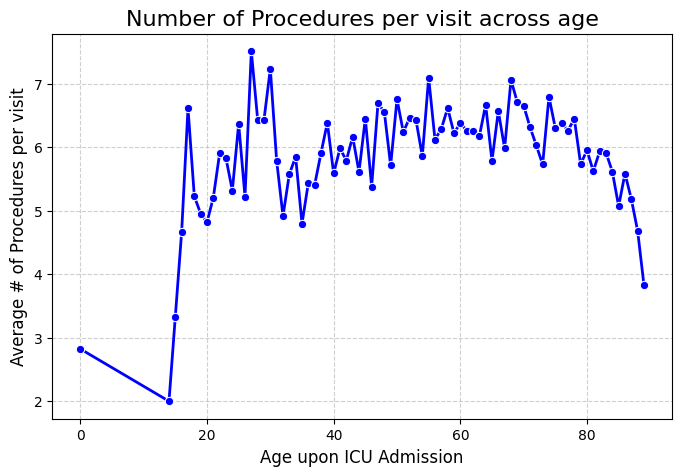

In [34]:
# Create a Line Plot
plt.figure(figsize=(8, 5))
lineplot = sns.lineplot(data=avg_proc_across_age, x='age_at_ICU', y='num_procedures', marker='o', color='blue', linewidth=2)

# Add Labels and Title
plt.title('Number of Procedures per visit across age', fontsize=16)
plt.xlabel('Age upon ICU Admission', fontsize=12)
plt.ylabel('Average # of Procedures per visit', fontsize=12)

for line in lineplot.lines:
    line.set_markerfacecolor('blue')

# Show Grid
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Show the Plot
plt.show()
